Script to animate particles released in the Tanzania domain

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from scipy.spatial import KDTree
from datetime import datetime, timedelta
import random
from matplotlib.animation import FuncAnimation, PillowWriter, writers
import matplotlib.animation as animation
import json


In [5]:
extent_thin = extent_thin = [38.5, 42.5, -4.48427153 , -10.5289526]
real_domain = [38.5, 42.5, -2.178355, -10.5289526]
real_domain_plusone = [38.5-1, 42.5+1, -2.178355+1, -10.5289526-1]

In [6]:
new_corals_lat=np.load('/mnt/iscsi2/OceanParcels/InputObsDom/corals_grp_latitude.npy')
new_corals_lon=np.load('/mnt/iscsi2/OceanParcels/InputObsDom/corals_grp_longitude.npy')

In [106]:
ds_part= xr.open_zarr("/mnt/iscsi2/OceanParcels/resultsObsDom/April99_100days.zarr")

In [107]:
simT = np.arange(datetime(1999,4,1,18,00), datetime(1999,4,30,18,00), timedelta(hours=1)).astype(datetime)

In [108]:
time_reduced_0 = ds_part.time.isel(obs=0).values
lon_reduced_0 = ds_part.lon.isel(obs=0).values
lat_reduced_0 = ds_part.lat.isel(obs=0).values

In [109]:
with open("colormap.json", "r") as f:
    colormap = json.load(f)
colormap = {int(k): v for k, v in colormap.items()}

In [110]:
# Step 2: Define the unique values (e.g., 0 to 37)
unique_values = [int(val) for val in np.arange(38)]

# Map each unique value to a specific color
value_to_color = {val: colormap[i] for i, val in enumerate(unique_values)}
colors_assigned = [value_to_color[val] for val in unique_values]

In [111]:
# Combine coral reef points into a single array
reef_points = np.column_stack((new_corals_lon, new_corals_lat))

# Build KDTree for coral reef points
reef_tree = KDTree(reef_points)

# Query KDTree for closest reef point to each starting point
distances, indices = reef_tree.query(np.column_stack((lon_reduced_0, lat_reduced_0)), k=1)

# Get closest reef points
closest_reef_lon = new_corals_lon[indices]
closest_reef_lat = new_corals_lat[indices]

In [112]:
unique_numbers = {}
for idx, num in enumerate(indices):
    if num not in unique_numbers:
        unique_numbers[num] = idx

In [113]:
unique_numbers = sorted(unique_numbers.items(), key=lambda kv: kv[0])
positions = [item[1] for item in unique_numbers]

In [114]:
target_lat=ds_part['lat'][positions,0].values
target_lon=ds_part['lon'][positions,0].values

In [115]:
matching_indices=np.zeros((29*12,38))
for i in np.arange(0,38):
    condition=(ds_part.lat.isel(obs=0) ==target_lat[i]) & (ds_part.lon.isel(obs=0) == target_lon[i])
    matching_indices[:,i] = np.where(condition)[0]

In [116]:
matching_indices=matching_indices.astype(int)

In [117]:
lon=np.zeros((70,38,300))
lat=np.zeros((70,38,300))
for i in range(70):
    lon[i,:,:]=ds_part['lon'][matching_indices[i,:],0:300]
    lat[i,:,:]=ds_part['lat'][matching_indices[i,:],0:300]

In [118]:
start_times = np.concatenate((np.arange(0,12), np.arange(24,36), np.arange(48,60),np.arange(72,84),np.arange(96,108)))

In [119]:
num_rel=np.size(start_times)
nframe=24*10

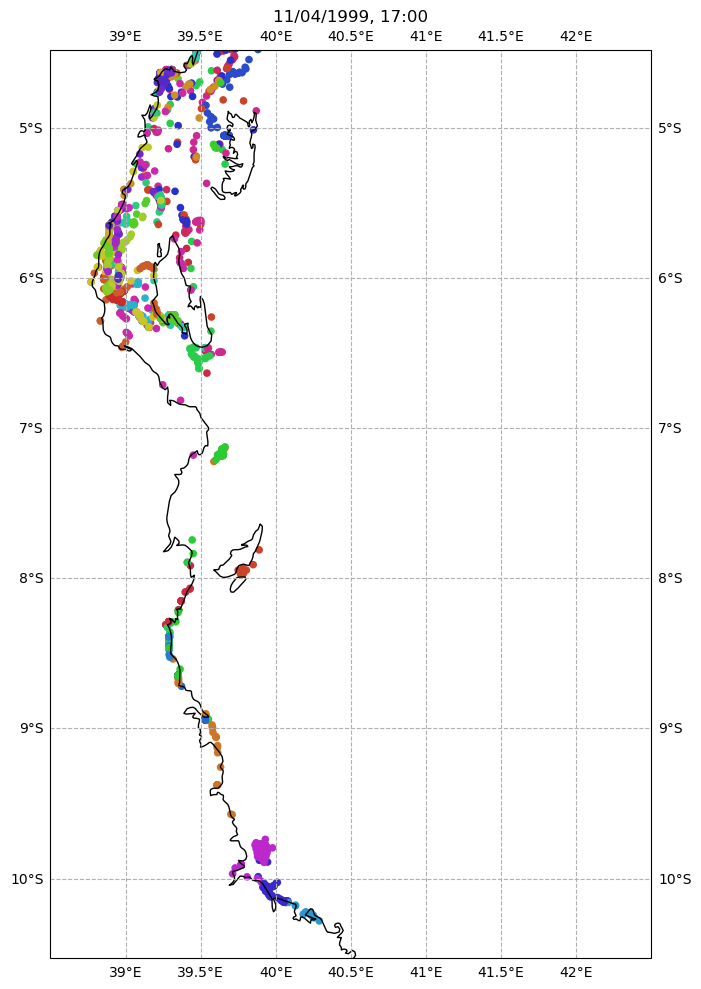

In [120]:
fig=plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, linestyle='--')
ax.set_extent(extent_thin, crs=ccrs.PlateCarree())
scatters=[ax.scatter([], [], s=20, transform=ccrs.PlateCarree())for i in range(num_rel)]

def update(frame): 
    for i in range(num_rel):
        # Check if the frame is within the active range for the group
        if start_times[i] <= frame < start_times[i] + nframe:
            relative_frame = frame - start_times[i]
            current_positions = np.c_[lon[i, :, relative_frame], lat[i, :, relative_frame]]
            # Update scatter plot for this group with fixed colors
            scatters[i].set_offsets(current_positions)
            scatters[i].set_facecolor(colors_assigned)
        else:
            # Keep particles invisible if outside active time
            scatters[i].set_offsets(np.array([[], []]).T)
            scatters[i].set_facecolor([])
            
        # Update title with the current timestamp
        ax.set_title(simT[frame].strftime("%d/%m/%Y, %H:%M"))
    return scatters


anim = animation.FuncAnimation(fig, update,frames=nframe,repeat=True)
anim
fig.canvas.draw()
plt.tight_layout()
writergif = PillowWriter(fps=5)
anim.save('/mnt/iscsi2/OceanParcels/OBS_Figures/Release_Apr99.gif',writer=writergif)